## Vector data analysis in Python

Setup: https://carpentries-incubator.github.io/geospatial-python/index.html

Based on: https://carpentries-incubator.github.io/geospatial-python/07-vector-data-in-python.html

Objectives:
* Load spatial objects.
* Select the spatial objects within a bounding box.
* Perform a CRS conversion of spatial objects.
* Select features of spatial objects.

* Before executing the code cells, be sure to replace the "_____" as appropriate

In [1]:
# First import necessary libraries
import geopandas as gpd #Extends pandas to allow spatial operations. Docs https://geopandas.org/en/stable/

In [2]:
# Use the geopandas package to load the crop field vector data we downloaded
boundary = gpd.read_file("data/co4060910587920200813_20180915_20210907_burn_bndy.shp")

In [3]:
# Show the data, notice the geometry column
boundary

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CO4060910587920200813,53741A13-D269-4CD5-AF91-02E094B944DA,CAMERON PEAK,Wildfire,10019755,RAVG,Extended,2439,40.527,-105.234,...,None,-3,28,0,0,92,156,230,None,"POLYGON ((-771811.757 1981074.506, -771814.499..."
1,CO4060910587920200813,53741A13-D269-4CD5-AF91-02E094B944DA,CAMERON PEAK,Wildfire,10019755,RAVG,Extended,206407,40.62,-105.558,...,None,-3,28,0,0,92,156,230,None,"MULTIPOLYGON (((-800256.471 2010330.829, -8002..."


In [4]:
# Show the geometry types
boundary.type

0         Polygon
1    MultiPolygon
dtype: object

In [5]:
# Show the bounds
boundary.total_bounds

array([-830114.0602   , 1976597.7957   , -771740.1755287, 2014899.8509   ])

In [6]:
# Show the coordinate reference system (crs)
boundary.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

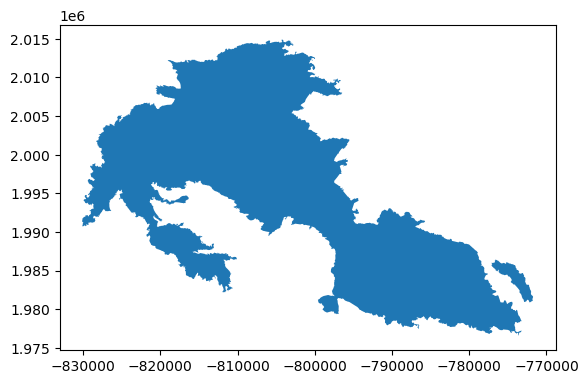

In [7]:
# Plot the data
boundary.plot()

## Selecting spatial features

In [8]:
# Lets now subset the data

# Use an interactive map to define a bounding box we'll later use to clip with
import folium # to create an interactive map
from folium.plugins import Draw # to allow drawing

# Define a center point using EPSG:4326 coordinates
center_coord = [40.60104027382292, -105.09137099497742] # fort collins

# Create the map
m  = folium.Map(center_coord, zoom_start=10)

boundary['Ig_Date'] = boundary['Ig_Date'].astype(str) # otherwise error "Object of type Timestamp is not JSON serializable"

# Add the data to the map
folium.GeoJson(boundary).add_to(m)

# Enable drawing on the map
draw = Draw(export=True)
draw.add_to(m)

m

# Use the draw rectangle tool to create a shape that overlaps a portion of the boundary

In [9]:
# Copy the geojson from the drawn polygon (click the shape, and copy the text starting from '{"type":"Polygon"', up until the last '}').
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

# Paste geojson below
geojson: dict = {"type":"Polygon","coordinates":[[[-105.308075,40.489145],[-105.308075,40.575826],[-105.191345,40.575826],[-105.191345,40.489145],[-105.308075,40.489145]]]}


geom: Polygon = shape(geojson)

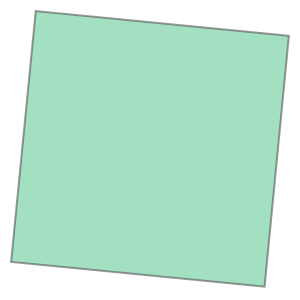

In [10]:
# Because our drawn geometry doesn't match the CRS of the loaded data, we need to transform it's projection
import pyproj # Load a reprojection library
from shapely.ops import transform # Load the shapely transform module 

# Create our 'from' and 'to' projection objects
from_proj = pyproj.CRS('EPSG:4326')
to_proj = pyproj.CRS('ESRI:102039')

# Create the transformer
project = pyproj.Transformer.from_crs(from_proj, to_proj, always_xy=True).transform

# Transform the data
geojson_projected = transform(project, geom)
geojson_projected

In [11]:
# Clip the 'boundary' data to our area of interest
boundary_cropped = gpd.clip(boundary,geojson_projected)

<Axes: >

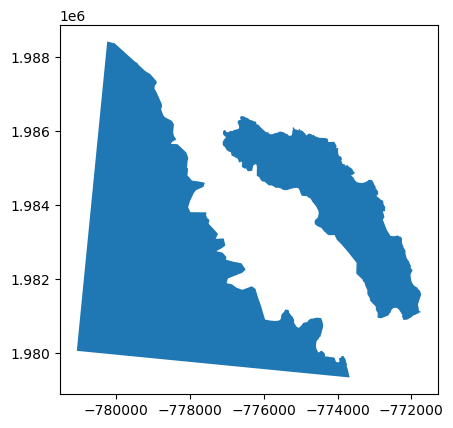

In [12]:
# Plot the data
boundary_cropped.plot()

In [13]:
# Show the results on an interactive map

center_coord = [40.60104027382292, -105.09137099497742] # fort collins
m  = folium.Map(center_coord, zoom_start=10)

# add original
folium.GeoJson(boundary).add_to(m)


boundary_cropped['Ig_Date'] = boundary_cropped['Ig_Date'].astype(str) # otherwise error "Object of type Timestamp is not JSON serializable"

# Add the cropped boundary data with a new style
folium.GeoJson(boundary_cropped,
    style_function=lambda feature: {
        "fillColor": "#ffff00",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    }).add_to(m)

# Add our area of interest
folium.GeoJson(geom).add_to(m)

draw = Draw(export=True)
draw.add_to(m)
m

In [14]:
# Export data to file
boundary_cropped.to_file('data/boundary_cropped.shp')

## Feature Services
Using REST APIs allow us to access the data we want without having to download massive files.
We'll user the FEMA US Stuctures data https://gis-fema.hub.arcgis.com/pages/usa-structures
This data has a download option but it's a large file
We'll instead use feature service https://fema.maps.arcgis.com/home/item.html?id=0ec8512ad21e4bb987d7e848d14e7e24#overview 
We can query feature service based off of our cropped boundary

In [15]:
# Go to the service URL https://services2.arcgis.com/FiaPA4ga0iQKduv3/arcgis/rest/services/USA_Structures_View/FeatureServer
# From url above, click the 'Query' link, then review the documentation
# Docs: https://developers.arcgis.com/rest/services-reference/enterprise/query-feature-service-layer/

# We've created the following URL so that we can access all the properties ('&outFields=*') and pass a boundary of our choosing ('&geometry=')
rest_url="https://services2.arcgis.com/FiaPA4ga0iQKduv3/ArcGIS/rest/services/USA_Structures_View/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometryType=esriGeometryEnvelope&inSR=4326&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&returnCentroid=false&returnEnvelope=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnTrueCurves=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=&outFields=*&geometry="#-104%2C35.6%2C-94.32%2C41

In [16]:
# Buffer our drawn bounds by 50m
geojson_projected_buffered = geojson_projected.buffer(50)
print(geojson_projected_buffered.bounds)

(-781106.329996593, 1979054.6721254555, -770304.3912704625, 1989770.961076489)


In [17]:
# We'll need to again reproject our area of interest

project_back = pyproj.Transformer.from_crs(to_proj,from_proj, always_xy=True).transform

geojson_projected_buffered_back = transform(project_back, geojson_projected_buffered)
str_bounds = ",".join(str(x) for x in geojson_projected_buffered_back.bounds)

# Add our reprojected bounds to the end of 'rest_url'
full_url=rest_url+str_bounds

In [18]:
# Load the data
structures = gpd.read_file(full_url)

In [19]:
# Show the data's shape
structures.shape

(481, 31)

In [20]:
# Show the column names and type
structures.dtypes

OBJECTID            int32
BUILD_ID            int32
OCC_CLS            object
PRIM_OCC           object
SEC_OCC            object
PROP_ADDR          object
PROP_CITY          object
PROP_ST            object
PROP_ZIP           object
OUTBLDG            object
HEIGHT             object
SQMETERS          float64
SQFEET            float64
H_ADJ_ELEV         object
L_ADJ_ELEV         object
FIPS               object
CENSUSCODE         object
PROD_DATE           int64
SOURCE             object
USNG               object
LONGITUDE         float64
LATITUDE          float64
IMAGE_NAME         object
IMAGE_DATE          int64
VAL_METHOD         object
REMARKS            object
UUID               object
STATE_FIPS         object
Shape__Area       float64
Shape__Length     float64
geometry         geometry
dtype: object

In [21]:
# Visualize the data on an interactive map

# Use our buffered area of interest for the map's center position
center_coord = [geojson_projected_buffered_back.centroid.y, geojson_projected_buffered_back.centroid.x] # fort collins
m  = folium.Map(center_coord, zoom_start=14)

# Add our buffer to the map
folium.GeoJson(geojson_projected_buffered_back).add_to(m)

# Add 'structures' with popups 
# See docs: https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html
popup = folium.GeoJsonPopup(fields=["OCC_CLS"])
folium.GeoJson(structures, popup=popup, popup_keep_highlighted=True,).add_to(m)

m

In [22]:
# Export structures geometry
# structures.to_file('data/structures.shp') # error Column names longer than 10...
structures.to_file('data/structures.gpkg')